# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict

We'll try to write some TensorFlow code to predict the price of Bitcoin based on the historical data of the Bitcoin itself.

## Get data
We're going to be using historical price data of BTC. Data has been downloaded from Yahoo Finance service.

In [7]:
# Import data with pandas
import pandas as pd

# Read in BTC data and pass the dates
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BTC-USD.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas that column 1 is datetime format

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [8]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-03,28680.494141,29259.533203,28178.388672,29006.308594,29006.308594,19122972518
2023-05-04,29031.304688,29353.185547,28694.039063,28847.710938,28847.710938,15548678514
2023-05-05,28851.480469,29668.908203,28845.509766,29534.384766,29534.384766,17936566518
2023-05-06,29538.859375,29820.126953,28468.966797,28904.623047,28904.623047,15913866714
2023-05-07,28916.708984,29151.941406,28788.570313,28897.636719,28897.636719,11557177344


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3155 entries, 2014-09-17 to 2023-05-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3155 non-null   float64
 1   High       3155 non-null   float64
 2   Low        3155 non-null   float64
 3   Close      3155 non-null   float64
 4   Adj Close  3155 non-null   float64
 5   Volume     3155 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 172.5 KB


In [10]:
# How many samples do we have?
len(df)

3155

In [11]:
# How many years is this?
3155/365

8.643835616438356

We've collected the historical price of BTC (from past 8,5 years or so) which gave exactly 3155 samples. 

Typically deep learning models thrive when being fed lots and lots of samples (where 'lots and lots' can be millions or more). 

A smaller number of samples is something you'll often run into while working with the time series problem.

> **NOTE**: The *seasonality* of a time series dataset is referred as the number of samples per year in given series. For our BTC data, it has seasonality of *daily* or value of *365* which speaks for itself.

In [12]:
# Only leave the closing price per each day
bitcoin_prices = pd.DataFrame(df['Close']).rename(columns={'Close': 'Price'})
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-05-03,29006.308594
2023-05-04,28847.710938
2023-05-05,29534.384766


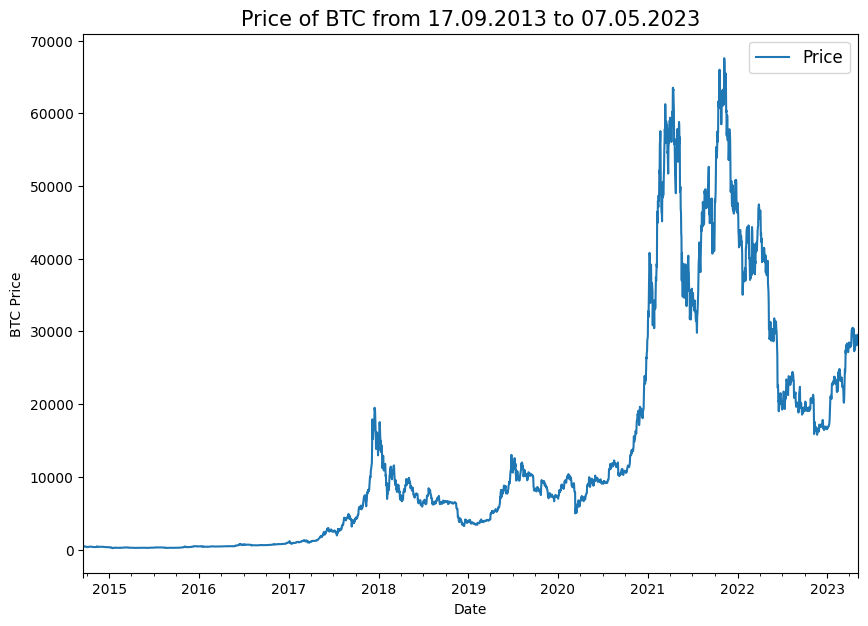

In [13]:
# Visualize the BTC price
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10,7))
plt.ylabel('BTC Price')
plt.title('Price of BTC from 17.09.2013 to 07.05.2023', fontsize=15)
plt.legend(fontsize=12)

## Importing time series data with Python's CSV module

In [14]:
# Importing and formatting data with Python CSV library
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/drive/MyDrive/Colab Notebooks/BTC-USD.csv", 'r') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=",")
  next(csv_reader) # goes through the iterator and ignores/skips next line - first line in our example
  
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates, not as strings
    btc_price.append(float(line[4])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 9, 17, 0, 0),
  datetime.datetime(2014, 9, 18, 0, 0),
  datetime.datetime(2014, 9, 19, 0, 0),
  datetime.datetime(2014, 9, 20, 0, 0),
  datetime.datetime(2014, 9, 21, 0, 0),
  datetime.datetime(2014, 9, 22, 0, 0),
  datetime.datetime(2014, 9, 23, 0, 0),
  datetime.datetime(2014, 9, 24, 0, 0),
  datetime.datetime(2014, 9, 25, 0, 0),
  datetime.datetime(2014, 9, 26, 0, 0)],
 [457.334015,
  424.440002,
  394.79599,
  408.903992,
  398.821014,
  402.152008,
  435.790985,
  423.204987,
  411.574005,
  404.424988])

Text(0, 0.5, 'BTC price')

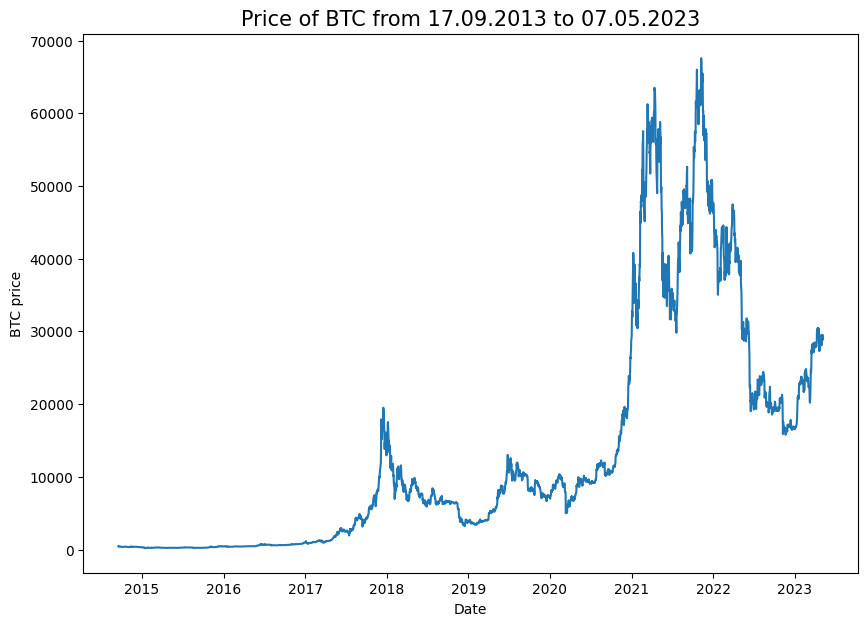

In [15]:
# Plot from Python CSV
import numpy as np

plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.title("Price of BTC from 17.09.2013 to 07.05.2023", fontsize=15)
plt.xlabel("Date")
plt.ylabel("BTC price")

## Format data part 1: Create train and test sets of our times series data

### Creating training and test sets with time series data (the wrong way)

In [16]:
# Get bitcoin data array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()
timesteps[:10], prices[:10]

(array(['2014-09-17T00:00:00.000000000', '2014-09-18T00:00:00.000000000',
        '2014-09-19T00:00:00.000000000', '2014-09-20T00:00:00.000000000',
        '2014-09-21T00:00:00.000000000', '2014-09-22T00:00:00.000000000',
        '2014-09-23T00:00:00.000000000', '2014-09-24T00:00:00.000000000',
        '2014-09-25T00:00:00.000000000', '2014-09-26T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
        402.152008, 435.790985, 423.204987, 411.574005, 404.424988]))

In [17]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2524,), (631,), (2524,), (631,))

Text(0.5, 1.0, 'Comparison of train and test datasets')

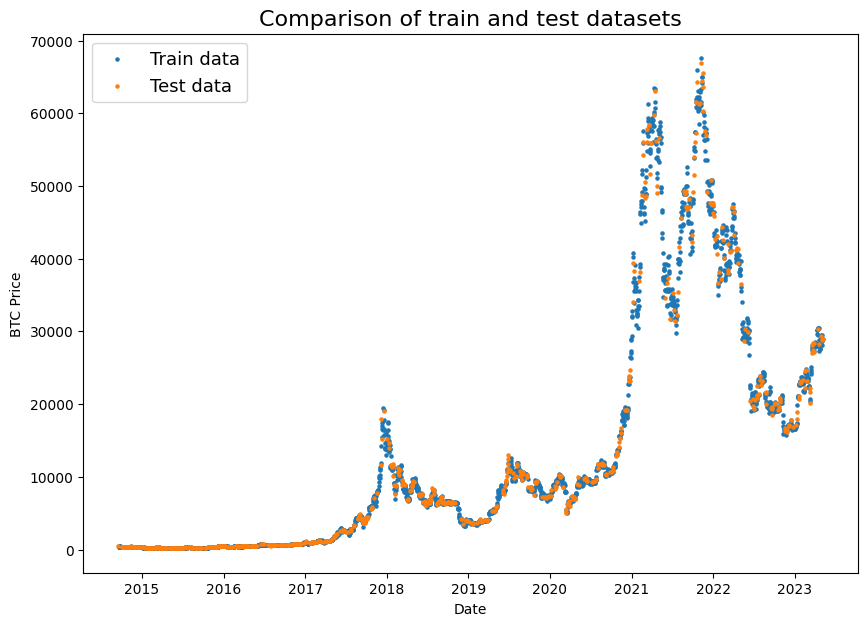

In [18]:
# Plotting wrong splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=13)
plt.title('Comparison of train and test datasets', fontsize=16)

### Create the train and test sets for time series (the proper way)

In [19]:
split_size = int(0.8 * len(prices)) # 80% test, 20% test; can be changed as needed

# Create proper splits
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2524, 631, 2524, 631)

Text(0.5, 1.0, 'Comparison of train and test datasets')

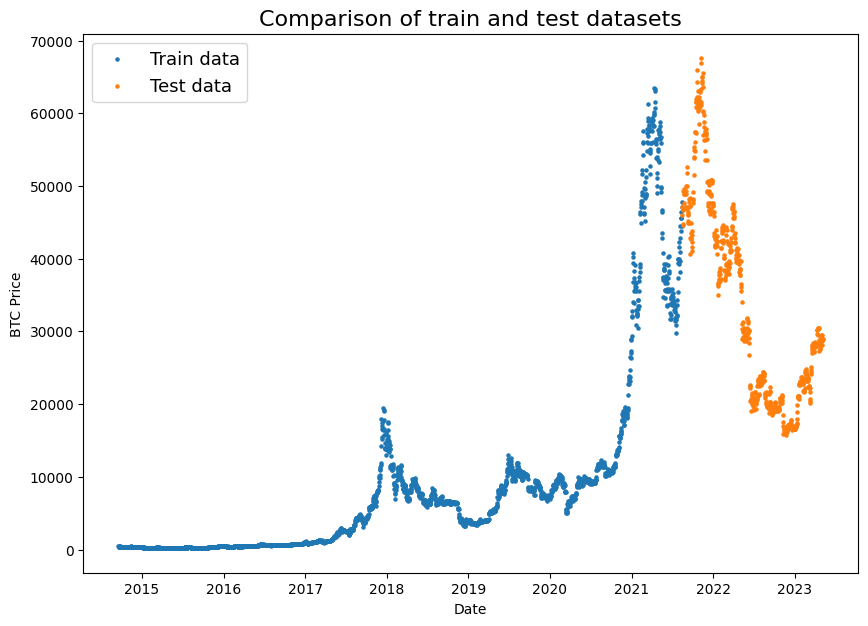

In [20]:
# Plot the correct splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=13)
plt.title('Comparison of train and test datasets', fontsize=16)

## Create a plotting function
As typing plotting code is tedious, it's time to functionize it.

In [21]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) againt values (a series of values across timesteps).

  Parameters:
  -----------
  timesteps : array of timestep values
  values : array of values across time
  format: style of plot, default "."
  start: where to start the plot (indexing from start of timesteps and values)
  end: same as above, but end
  label: label to show on plot about values, default None
  """
  # Plot the series
  #plt.figure(figsize=(10,7))
  plt.plot(timesteps[start:end],
           values[start:end],
           format,
           label=label)
  
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

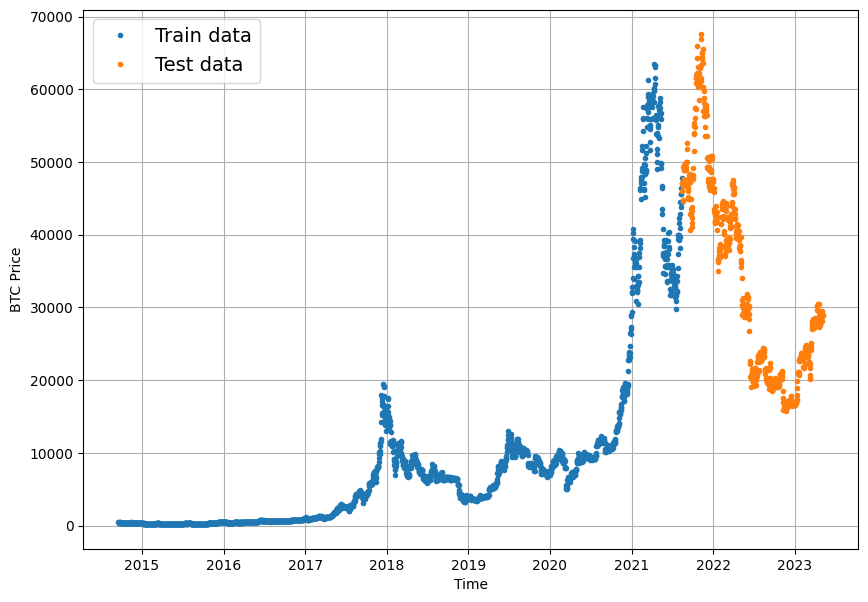

In [22]:
# Test the plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,
                 values=y_train,
                 label='Train data')
plot_time_series(timesteps=X_test,
                 values=y_test,
                 label='Test data')

## Modelling experiments

We've got some historical Bitcoin data. It's about time to note down the experiments we'd like to run.

Terms to be familiar with:
* *horizon* - steps into the future to predict
* *window size* - number of timestep to be used to predict the *horizon*

Experiments will be as follows:
0. Naive based model (baseline)
1. Dense model: horizon = 1, window = 7
2. Same as model 1: horizon = 1, window = 7
3. Same as model 1: horizon = 7, window = 30
4. Conv1D
5. LSTM
6. Same as model 1 (but with multivariate data)
7. N_BEATS algorithm
8. Ensemble (multiple models stacked together)
9. Future prediction model
10. Same as model 1 (but with turkey data introduced)

## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

> The prediction at timestep **t** (y-hat) is equal to the value at timestep **t-1** (previous timestep) - this is for a horizon of 1.

Lecture for this section:
https://otexts.com/fpp3/simple-methods.html

In [23]:
# Creating a naive forecast 
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([47047.003906, 46004.484375, 44695.359375, 44801.1875  ,
        46717.578125, 49339.175781, 48905.492188, 49321.652344,
        49546.148438, 47706.117188]),
 array([29473.787109, 29340.261719, 29248.488281, 29268.806641,
        28091.568359, 28680.537109, 29006.308594, 28847.710938,
        29534.384766, 28904.623047]))

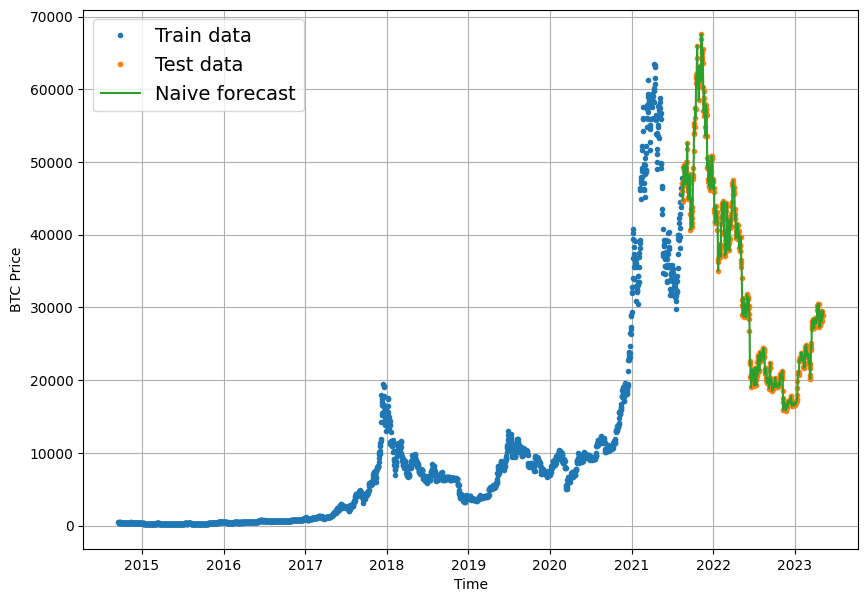

In [24]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format='-', label='Naive forecast') # because of shapes, we need to cut the first value

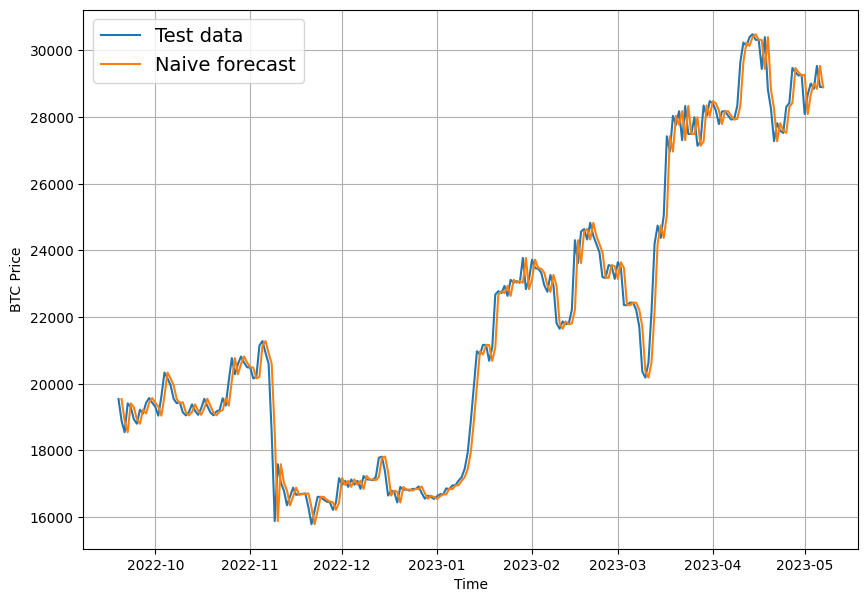

In [25]:
# Plot naive forecast - zoomed in version
plt.figure(figsize=(10, 7))
#plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, start=400, format='-', label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=400, format='-', label='Naive forecast') # because of shapes, we need to cut the first value

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing? 

Predicting a number, so that means our problem is a **regression** problem. 

Because we're working on a regression problem, we're going to need some regression-like metrics.

A few common regression metrics, which also can be use for time series forecasting, are:
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean sqaured error
* MAPE (sMAPE)- (scaled) mean absolute percentage error
* MASE - mean absolute scaled error

Main thing we're evaluating here is: **how do our model's forecast (`y_pred`) compare agains the actual values (`y_true`).**

### Creating MASE function

In [26]:
import tensorflow as tf

In [27]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE metric (assuming no seasonality of data).
  """

  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [28]:
mean_absolute_scaled_error(y_true=y_test[1:],
                           y_pred=naive_forecast).numpy()

1.0005690752533343

### Create a function for all of the metrics

In [29]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure data is float32 (default TensorFlow dtype)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true=y_true, y_pred=y_pred)

  # Return a dictionary
  return {'mae': mae.numpy(),
          'mse': mse.numpy(),
          'rmse': rmse.numpy(),
          'mape': mape.numpy(),
          'mase': mase.numpy()}

In [30]:
# Get the Naive forecast results
naive_results = evaluate_preds(y_true=y_test[1:], 
                               y_pred=naive_forecast)
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

In [31]:
# Average, min & max price
print(f"Average price: {tf.reduce_mean(y_test):.2f} USD") 
print(f"Minimum price: {tf.reduce_min(y_test):.2f} USD") 
print(f"Maximum price: {tf.reduce_max(y_test):.2f} USD")

Average price: 32882.82 USD
Minimum price: 15787.28 USD
Maximum price: 67566.83 USD


## Other model you can use for baselines and for actual forecasts
In this notebook, the main focus is on TensorFlow and building deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with:
https://github.com/mrdbourke/tensorflow-deep-learning#-10-time-series-fundamentals-and-milestone-project-3-bitpredict--exercises

## Format data part 2: Windowing our dataset
Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [32]:
# What we want to do with our BTC data
print(f"We want to use this: {btc_price[:7]} \nto predict this: {btc_price[7]}")

We want to use this: [457.334015, 424.440002, 394.79599, 408.903992, 398.821014, 402.152008, 435.790985] 
to predict this: 423.204987


In [33]:
# Setting up global variables for window and horizon size
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use past 7 days to make a prediction

In [34]:
# Create a function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Create labels for windowed dataset.

  E.g.:
    if horizon = 1:
      Input = [0, 1, 2, 3, 4, 5, 6, 7]
      Output = ([0, 1, 2, 3, 4, 5, 6], [7])
  """

  return x[:, :-horizon], x[:, -horizon:]

In [35]:
# Test the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data. However, it only works on a small scale.

We need the way to do the above across our entire time series...

We could do this with Python `for()` loops, however for large time series that would be quite slow.

To speed things up, we'll leverage `NumPy`'s array indexing.

The function will:
1. Create a windows step of a specific window size.
2. Use `Numpy` indexing to create 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]...]
```
3. Uses the 2D array of multiple window step to index on a target series. 
4. Uses our `get_labelled_windows()` function to turn the window steps into windows with a specifide horizon.

> **Resource**: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [36]:
import numpy as np

# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows
  of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (plus horizon)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window step (minus 1 to account for indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  #print(window_indexes, window_indexes.shape)

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  #print(windowed_array)

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [37]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(3148, 3148)

In [38]:
# View the first 3 windows and labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [457.334015 424.440002 394.79599  408.903992 398.821014 402.152008
 435.790985] -> Label: [423.204987]
Window: [424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987] -> Label: [411.574005]
Window: [394.79599  408.903992 398.821014 402.152008 435.790985 423.204987
 411.574005] -> Label: [404.424988]


In [39]:
# View the last 3 windows
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [29340.261719 29248.488281 29268.806641 28091.568359 28680.537109
 29006.308594 28847.710938] -> Label: [29534.384766]
Window: [29248.488281 29268.806641 28091.568359 28680.537109 29006.308594
 28847.710938 29534.384766] -> Label: [28904.623047]
Window: [29268.806641 28091.568359 28680.537109 29006.308594 28847.710938
 29534.384766 28904.623047] -> Label: [28897.636719]


> **NOTE**: There's a function that does similar to the above in `tf.keras.preprocessing`. You can try to replicate the above using said function.

Resource: https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

In [40]:
# Another approach - data not separated as for window and horizon
sequence = tf.keras.utils.timeseries_dataset_from_array(data=prices,
                                                        targets=None,
                                                        sequence_length=8,
                                                        sequence_stride=1,
                                                        sampling_rate=1,
                                                        batch_size=32)

for batch in sequence:
  print(batch)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  587.801025 592.103027]
 [578.289001 575.04303  587.778015 592.690002 591.054016 587.801025
  592.103027 589.119995]
 [575.04303  587.778015 592.690002 591.054016 587.801025 592.103027
  589.119995 587.559021]
 [587.778015 592.690002 591.054016 587.801025 592.103027 589.119995
  587.559021 585.588013]
 [592.690002 591.054016 587.801025 592.103027 589.119995 587.559021
  585.588013 570.473022]
 [591.054016 587.801025 592.103027 589.119995 587.559021 585.588013
  570.473022 567.23999 ]
 [587.801025 592.103027 589.119995 587.559021 585.588013 570.473022
  567.23999  577.439026]
 [592.103027 589.119995 587.559021 585.588013 570.473022 567.23999
  577.439026 573.216003]
 [589.119995 587.559021 585.588013 570.473022 567.23999  577.439026
  573.216003 574.317993]
 [587.559021 585.588013 570.473022 567.23999  577.439026 573.216003
  574.317993 575.630005]
 [585.588013 570.473022 567.23999  577.439026 573.216003 574.317993
  575.

In [41]:
# Another approach pt.2 - data separated as for window and horizon
input_data = prices[:-6]
targets = prices[7:]

sequence = tf.keras.utils.timeseries_dataset_from_array(data=input_data,
                                                        targets=targets,
                                                        sampling_rate=1,
                                                        sequence_length=7,
                                                        sequence_stride=1,
                                                        batch_size=32)


for batch in sequence:
  inputs, targets = batch
  #assert np.array_equal(inputs[0], prices[:7])
  #assert np.array_equal(targets[0], prices[7])
  #break
  print(inputs[1], targets[1])
print(prices[-10:])

tf.Tensor(
[424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987], shape=(7,), dtype=float64) tf.Tensor(411.574005, shape=(), dtype=float64)
tf.Tensor(
[382.845001 386.475006 383.15799  358.416992 358.345001 347.270996
 354.70401 ], shape=(7,), dtype=float64) tf.Tensor(352.989014, shape=(), dtype=float64)
tf.Tensor(
[350.847992 352.920013 367.572998 376.901001 375.347992 368.369995
 369.670013], shape=(7,), dtype=float64) tf.Tensor(376.446991, shape=(), dtype=float64)
tf.Tensor(
[334.571991 322.533997 319.007996 327.924011 315.863007 317.239014
 312.670013], shape=(7,), dtype=float64) tf.Tensor(310.737, shape=(), dtype=float64)
tf.Tensor(
[247.847    253.718002 273.472992 263.475006 233.914993 233.513
 226.425003], shape=(7,), dtype=float64) tf.Tensor(217.464005, shape=(), dtype=float64)
tf.Tensor(
[237.470001 236.425995 253.828003 254.263    260.201996 275.670013
 281.701996], shape=(7,), dtype=float64) tf.Tensor(273.09201, shape=(), dtype=float64)
tf.Tensor(


## Turning windows into training and test datasets

In [42]:
# Make the splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Split matching pairs of windows and labels into test and train
  datasets.
  """
  split_size = int(len(windows) * (1 - test_split)) # default to 80% train / 20% test

  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [43]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2518, 630, 2518, 630)

In [44]:
train_windows[:5], train_labels[:5]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005],
        [408.903992, 398.821014, 402.152008, 435.790985, 423.204987,
         411.574005, 404.424988],
        [398.821014, 402.152008, 435.790985, 423.204987, 411.574005,
         404.424988, 399.519989]]),
 array([[423.204987],
        [411.574005],
        [404.424988],
        [399.519989],
        [377.181   ]]))

In [45]:
# Chech to see if the train labels are the same (before and after the split)
np.array_equal(np.squeeze(train_labels[:-HORIZON]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate, `ModelCheckpoint` is quite useful. This way we can compare apples to apples.

More specifically, we want to compare each of our model's best perfoemance against the other model's best performance.

For example, if our model performs best on epoch 55, but the training is for 100 epochs, we'd like to load and evaluate the model on the best epoch there was.


In [46]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path='model_experiments'):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=1,
                                            save_best_only=True,
                                            monitor='val_loss')

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 units and ReLU activation funciton
* An output layer with a linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size = 128 (previously we've used 32)
* Epochs = 100

Why these values? They were picked out of experimenation.

* **Hyperparameters** = values a machine learning practitioner can adjust themselves.
* **Parameters** = values a model learns on its own.

In [47]:
import tensorflow as tf
from tensorflow.keras import layers

# Set the random seed
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear') # linear = no activation
], name='model_1_dense') # model name so we can save it

# 2. Compile the model
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

# 3. Fit the model
history_model_1 = model_1.fit(x=train_windows,
                              y=train_labels,
                              epochs=100,
                              verbose=1,
                              #batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
76/79 [===========================>..] - ETA: 0s - loss: 1497.1893 - mae: 1497.1893 - mse: 22660812.0000
Epoch 1: val_loss improved from inf to 1779.56885, saving model to model_experiments/model_1_dense


79/79 [==============================] - 10s 20ms/step - loss: 1467.8322 - mae: 1467.8322 - mse: 21950238.0000 - val_loss: 1779.5688 - val_mae: 1779.5688 - val_mse: 5685471.5000
Epoch 2/100
73/79 [==========================>...] - ETA: 0s - loss: 448.2635 - mae: 448.2635 - mse: 1091969.0000
Epoch 2: val_loss improved from 1779.56885 to 1163.27148, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 14ms/step - loss: 447.3892 - mae: 447.3892 - mse: 1073041.8750 - val_loss: 1163.2715 - val_mae: 1163.2715 - val_mse: 2834475.5000
Epoch 3/100
67/79 [========================>.....] - ETA: 0s - loss: 409.9229 - mae: 409.9229 - mse: 922859.8750
Epoch 3: val_loss improved from 1163.27148 to 1112.51123, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 14ms/step - loss: 406.5475 - mae: 406.5475 - mse: 902045.8125 - val_loss: 1112.5112 - val_mae: 1112.5112 - val_mse: 2465901.0000
Epoch 4/100
71/79 [=========================>....] - ETA: 0s - loss: 366.3947 - mae: 366.3947 - mse: 724482.6875
Epoch 4: val_loss did not improve from 1112.51123
79/79 [==============================] - 1s 7ms/step - loss: 375.1129 - mae: 375.1129 - mse: 786301.9375 - val_loss: 1387.2355 - val_mae: 1387.2355 - val_mse: 3630223.5000
Epoch 5/100
73/79 [==========================>...] - ETA: 0s - loss: 367.1105 - mae: 367.1105 - mse: 723412.0000
Epoch 5: val_loss improved from 1112.51123 to 1048.70154, saving model to model_experiments/model_1_dense


79/79 [==============================] - 2s 30ms/step - loss: 368.9892 - mae: 368.9892 - mse: 736829.1875 - val_loss: 1048.7015 - val_mae: 1048.7015 - val_mse: 2162703.7500
Epoch 6/100
79/79 [==============================] - ETA: 0s - loss: 373.2991 - mae: 373.2991 - mse: 755565.1875
Epoch 6: val_loss did not improve from 1048.70154
79/79 [==============================] - 1s 11ms/step - loss: 373.2991 - mae: 373.2991 - mse: 755565.1875 - val_loss: 1787.3800 - val_mae: 1787.3800 - val_mse: 5270902.5000
Epoch 7/100
70/79 [=========================>....] - ETA: 0s - loss: 358.2784 - mae: 358.2784 - mse: 723299.5625
Epoch 7: val_loss did not improve from 1048.70154
79/79 [==============================] - 1s 8ms/step - loss: 353.1674 - mae: 353.1674 - mse: 696227.5000 - val_loss: 1347.3466 - val_mae: 1347.3466 - val_mse: 3386908.7500
Epoch 8/100
69/79 [=========================>....] - ETA: 0s - loss: 356.7681 - mae: 356.7681 - mse: 667115.3125
Epoch 8: val_loss improved from 1048.70154 

79/79 [==============================] - 1s 18ms/step - loss: 350.1843 - mae: 350.1843 - mse: 645014.4375 - val_loss: 1032.2323 - val_mae: 1032.2323 - val_mse: 2246516.5000
Epoch 9/100
70/79 [=========================>....] - ETA: 0s - loss: 367.9720 - mae: 367.9720 - mse: 686625.8750
Epoch 9: val_loss improved from 1032.23230 to 913.46729, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 13ms/step - loss: 360.7091 - mae: 360.7091 - mse: 675530.0625 - val_loss: 913.4673 - val_mae: 913.4673 - val_mse: 1795652.5000
Epoch 10/100
69/79 [=========================>....] - ETA: 0s - loss: 320.2589 - mae: 320.2589 - mse: 588583.4375
Epoch 10: val_loss did not improve from 913.46729
79/79 [==============================] - 1s 6ms/step - loss: 320.2050 - mae: 320.2050 - mse: 589835.0625 - val_loss: 947.6318 - val_mae: 947.6318 - val_mse: 1829894.5000
Epoch 11/100
77/79 [============================>.] - ETA: 0s - loss: 317.7051 - mae: 317.7051 - mse: 567548.5625
Epoch 11: val_loss improved from 913.46729 to 887.85419, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 17ms/step - loss: 314.9160 - mae: 314.9160 - mse: 558048.6250 - val_loss: 887.8542 - val_mae: 887.8542 - val_mse: 1697671.0000
Epoch 12/100
75/79 [===========================>..] - ETA: 0s - loss: 326.0201 - mae: 326.0201 - mse: 580874.3125
Epoch 12: val_loss did not improve from 887.85419
79/79 [==============================] - 0s 6ms/step - loss: 324.8271 - mae: 324.8271 - mse: 587618.6875 - val_loss: 1054.3240 - val_mae: 1054.3240 - val_mse: 2283240.5000
Epoch 13/100
78/79 [============================>.] - ETA: 0s - loss: 300.5825 - mae: 300.5825 - mse: 534365.2500
Epoch 13: val_loss improved from 887.85419 to 884.44037, saving model to model_experiments/model_1_dense


79/79 [==============================] - 2s 23ms/step - loss: 300.4715 - mae: 300.4715 - mse: 532296.5625 - val_loss: 884.4404 - val_mae: 884.4404 - val_mse: 1724678.2500
Epoch 14/100
75/79 [===========================>..] - ETA: 0s - loss: 303.5927 - mae: 303.5927 - mse: 532231.4375
Epoch 14: val_loss improved from 884.44037 to 860.50488, saving model to model_experiments/model_1_dense


79/79 [==============================] - 2s 20ms/step - loss: 304.6629 - mae: 304.6629 - mse: 540267.1875 - val_loss: 860.5049 - val_mae: 860.5049 - val_mse: 1627183.6250
Epoch 15/100
76/79 [===========================>..] - ETA: 0s - loss: 299.7702 - mae: 299.7702 - mse: 525148.5000
Epoch 15: val_loss did not improve from 860.50488
79/79 [==============================] - 1s 8ms/step - loss: 298.1416 - mae: 298.1416 - mse: 521882.1250 - val_loss: 880.4299 - val_mae: 880.4299 - val_mse: 1640898.5000
Epoch 16/100
79/79 [==============================] - ETA: 0s - loss: 305.4454 - mae: 305.4454 - mse: 529332.8125
Epoch 16: val_loss improved from 860.50488 to 844.18829, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 18ms/step - loss: 305.4454 - mae: 305.4454 - mse: 529332.8125 - val_loss: 844.1883 - val_mae: 844.1883 - val_mse: 1577365.1250
Epoch 17/100
66/79 [========================>.....] - ETA: 0s - loss: 299.9043 - mae: 299.9043 - mse: 537944.7500
Epoch 17: val_loss did not improve from 844.18829
79/79 [==============================] - 1s 6ms/step - loss: 306.1223 - mae: 306.1223 - mse: 541299.7500 - val_loss: 1124.1431 - val_mae: 1124.1431 - val_mse: 2464636.7500
Epoch 18/100
77/79 [============================>.] - ETA: 0s - loss: 289.7592 - mae: 289.7592 - mse: 515795.0625
Epoch 18: val_loss did not improve from 844.18829
79/79 [==============================] - 0s 6ms/step - loss: 291.6448 - mae: 291.6448 - mse: 522816.0625 - val_loss: 877.2600 - val_mae: 877.2600 - val_mse: 1700371.8750
Epoch 19/100
71/79 [=========================>....] - ETA: 0s - loss: 313.9312 - mae: 313.9312 - mse: 580482.5625
Epoch 19: val_loss did not improve from 844.1

79/79 [==============================] - 1s 15ms/step - loss: 307.0595 - mae: 307.0595 - mse: 513505.1562 - val_loss: 827.0036 - val_mae: 827.0036 - val_mse: 1520700.1250
Epoch 24/100
77/79 [============================>.] - ETA: 0s - loss: 283.6515 - mae: 283.6515 - mse: 476490.0625
Epoch 24: val_loss did not improve from 827.00360
79/79 [==============================] - 0s 6ms/step - loss: 283.8615 - mae: 283.8615 - mse: 475907.9062 - val_loss: 1366.3329 - val_mae: 1366.3329 - val_mse: 3257432.5000
Epoch 25/100
68/79 [========================>.....] - ETA: 0s - loss: 307.9091 - mae: 307.9091 - mse: 564182.6875
Epoch 25: val_loss did not improve from 827.00360
79/79 [==============================] - 0s 5ms/step - loss: 292.9473 - mae: 292.9473 - mse: 523428.1875 - val_loss: 901.1908 - val_mae: 901.1908 - val_mse: 1755507.2500
Epoch 26/100
73/79 [==========================>...] - ETA: 0s - loss: 302.3482 - mae: 302.3482 - mse: 524612.5000
Epoch 26: val_loss did not improve from 827.0

79/79 [==============================] - 1s 10ms/step - loss: 284.2520 - mae: 284.2520 - mse: 486417.6875 - val_loss: 822.4273 - val_mae: 822.4273 - val_mse: 1553283.0000
Epoch 28/100
64/79 [=======================>......] - ETA: 0s - loss: 295.5460 - mae: 295.5460 - mse: 507294.2812
Epoch 28: val_loss did not improve from 822.42731
79/79 [==============================] - 0s 4ms/step - loss: 285.8364 - mae: 285.8364 - mse: 482898.1562 - val_loss: 1119.8497 - val_mae: 1119.8497 - val_mse: 2396563.7500
Epoch 29/100
64/79 [=======================>......] - ETA: 0s - loss: 282.4949 - mae: 282.4949 - mse: 486553.4688
Epoch 29: val_loss improved from 822.42731 to 795.45483, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 10ms/step - loss: 282.5116 - mae: 282.5116 - mse: 491837.8750 - val_loss: 795.4548 - val_mae: 795.4548 - val_mse: 1472245.3750
Epoch 30/100
68/79 [========================>.....] - ETA: 0s - loss: 280.5174 - mae: 280.5174 - mse: 490761.8438
Epoch 30: val_loss did not improve from 795.45483
79/79 [==============================] - 0s 4ms/step - loss: 282.8517 - mae: 282.8517 - mse: 489010.5312 - val_loss: 899.8704 - val_mae: 899.8704 - val_mse: 1670505.1250
Epoch 31/100
64/79 [=======================>......] - ETA: 0s - loss: 294.9966 - mae: 294.9966 - mse: 518966.4688
Epoch 31: val_loss improved from 795.45483 to 795.11481, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 10ms/step - loss: 287.3515 - mae: 287.3515 - mse: 487956.1875 - val_loss: 795.1148 - val_mae: 795.1148 - val_mse: 1472396.7500
Epoch 32/100
64/79 [=======================>......] - ETA: 0s - loss: 269.6802 - mae: 269.6802 - mse: 476425.5312
Epoch 32: val_loss did not improve from 795.11481
79/79 [==============================] - 0s 4ms/step - loss: 275.1054 - mae: 275.1054 - mse: 472797.5312 - val_loss: 1351.1245 - val_mae: 1351.1245 - val_mse: 3020518.7500
Epoch 33/100
72/79 [==========================>...] - ETA: 0s - loss: 325.1853 - mae: 325.1853 - mse: 618303.3750
Epoch 33: val_loss did not improve from 795.11481
79/79 [==============================] - 0s 6ms/step - loss: 317.3091 - mae: 317.3091 - mse: 592031.3125 - val_loss: 979.1581 - val_mae: 979.1581 - val_mse: 1861257.0000
Epoch 34/100
67/79 [========================>.....] - ETA: 0s - loss: 293.0724 - mae: 293.0724 - mse: 505483.4062
Epoch 34: val_loss did not improve from 795.1

79/79 [==============================] - 1s 11ms/step - loss: 295.5948 - mae: 295.5948 - mse: 521979.3125 - val_loss: 789.1658 - val_mae: 789.1658 - val_mse: 1459866.3750
Epoch 42/100
78/79 [============================>.] - ETA: 0s - loss: 280.1626 - mae: 280.1626 - mse: 472471.5938
Epoch 42: val_loss did not improve from 789.16577
79/79 [==============================] - 0s 4ms/step - loss: 282.0979 - mae: 282.0979 - mse: 479593.8438 - val_loss: 805.1259 - val_mae: 805.1259 - val_mse: 1469478.0000
Epoch 43/100
70/79 [=========================>....] - ETA: 0s - loss: 287.0803 - mae: 287.0803 - mse: 508813.9375
Epoch 43: val_loss did not improve from 789.16577
79/79 [==============================] - 0s 5ms/step - loss: 280.7309 - mae: 280.7309 - mse: 484763.1875 - val_loss: 861.7843 - val_mae: 861.7843 - val_mse: 1636824.0000
Epoch 44/100
67/79 [========================>.....] - ETA: 0s - loss: 271.3484 - mae: 271.3484 - mse: 441211.5938
Epoch 44: val_loss did not improve from 789.165

79/79 [==============================] - 1s 14ms/step - loss: 280.4298 - mae: 280.4298 - mse: 469471.5625 - val_loss: 781.6583 - val_mae: 781.6583 - val_mse: 1430558.1250
Epoch 61/100
76/79 [===========================>..] - ETA: 0s - loss: 274.4760 - mae: 274.4760 - mse: 456072.9062
Epoch 61: val_loss improved from 781.65833 to 781.30908, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 16ms/step - loss: 277.5241 - mae: 277.5241 - mse: 473702.2188 - val_loss: 781.3091 - val_mae: 781.3091 - val_mse: 1436493.0000
Epoch 62/100
77/79 [============================>.] - ETA: 0s - loss: 283.8686 - mae: 283.8686 - mse: 489212.0000
Epoch 62: val_loss improved from 781.30908 to 779.01489, saving model to model_experiments/model_1_dense


79/79 [==============================] - 1s 15ms/step - loss: 284.2869 - mae: 284.2869 - mse: 487371.3750 - val_loss: 779.0149 - val_mae: 779.0149 - val_mse: 1428801.8750
Epoch 63/100
74/79 [===========================>..] - ETA: 0s - loss: 268.9122 - mae: 268.9122 - mse: 446766.8750
Epoch 63: val_loss did not improve from 779.01489
79/79 [==============================] - 0s 6ms/step - loss: 274.6445 - mae: 274.6445 - mse: 454809.2188 - val_loss: 1156.7206 - val_mae: 1156.7206 - val_mse: 2480234.0000
Epoch 64/100
77/79 [============================>.] - ETA: 0s - loss: 285.5090 - mae: 285.5090 - mse: 510153.9375
Epoch 64: val_loss did not improve from 779.01489
79/79 [==============================] - 0s 5ms/step - loss: 284.7217 - mae: 284.7217 - mse: 508955.0938 - val_loss: 793.5222 - val_mae: 793.5222 - val_mse: 1441931.0000
Epoch 65/100
70/79 [=========================>....] - ETA: 0s - loss: 263.7104 - mae: 263.7104 - mse: 408678.7812
Epoch 65: val_loss did not improve from 779.0

79/79 [==============================] - 2s 21ms/step - loss: 285.1481 - mae: 285.1481 - mse: 489986.6875 - val_loss: 777.4470 - val_mae: 777.4470 - val_mse: 1427533.7500
Epoch 79/100
76/79 [===========================>..] - ETA: 0s - loss: 273.9256 - mae: 273.9256 - mse: 449145.3750
Epoch 79: val_loss did not improve from 777.44702
79/79 [==============================] - 1s 11ms/step - loss: 274.0219 - mae: 274.0219 - mse: 443895.2188 - val_loss: 882.3461 - val_mae: 882.3461 - val_mse: 1681738.1250
Epoch 80/100
78/79 [============================>.] - ETA: 0s - loss: 273.6710 - mae: 273.6710 - mse: 468597.6562
Epoch 80: val_loss did not improve from 777.44702
79/79 [==============================] - 1s 10ms/step - loss: 274.9321 - mae: 274.9321 - mse: 470749.0312 - val_loss: 1200.4941 - val_mae: 1200.4941 - val_mse: 2623174.0000
Epoch 81/100
77/79 [============================>.] - ETA: 0s - loss: 270.5186 - mae: 270.5186 - mse: 430817.9688
Epoch 81: val_loss did not improve from 777

79/79 [==============================] - 3s 33ms/step - loss: 304.0056 - mae: 304.0056 - mse: 537693.3125 - val_loss: 776.2674 - val_mae: 776.2674 - val_mse: 1427948.8750
Epoch 88/100
79/79 [==============================] - ETA: 0s - loss: 327.2502 - mae: 327.2502 - mse: 612131.0625
Epoch 88: val_loss did not improve from 776.26740
79/79 [==============================] - 1s 13ms/step - loss: 327.2502 - mae: 327.2502 - mse: 612131.0625 - val_loss: 871.8496 - val_mae: 871.8496 - val_mse: 1598544.0000
Epoch 89/100
76/79 [===========================>..] - ETA: 0s - loss: 273.9384 - mae: 273.9384 - mse: 454426.0000
Epoch 89: val_loss did not improve from 776.26740
79/79 [==============================] - 1s 13ms/step - loss: 270.6969 - mae: 270.6969 - mse: 444604.6562 - val_loss: 777.7106 - val_mae: 777.7106 - val_mse: 1419277.1250
Epoch 90/100
77/79 [============================>.] - ETA: 0s - loss: 282.0995 - mae: 282.0995 - mse: 487103.1562
Epoch 90: val_loss did not improve from 776.2

In [48]:
# Evaluate the model
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 4ms/step - loss: 869.1304 - mae: 869.1304 - mse: 1588640.2500


[869.1304321289062, 869.1304321289062, 1588640.25]

In [49]:
# Load in the saved, best performat model
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense')
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 5ms/step - loss: 776.2674 - mae: 776.2674 - mse: 1427948.8750


[776.2673950195312, 776.2673950195312, 1427948.875]

### Make forecasts with a model (on the test dataset)

To make 'forecasts' on the test dataset, let's write a function to:
1. Takes in a trained model
2. Takes in some input data
3. Passes the input to the `predict()` method
4. Returns the predictions

In [50]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # 1D array of preds as output

In [51]:
# Make predictions using model_1
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:10], len(model_1_preds)

20/20 [==============================] - 0s 3ms/step


(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([47162.61 , 46065.98 , 44838.895, 44775.23 , 46508.453, 49237.383,
        49185.105, 49345.3  , 49566.73 , 48074.996], dtype=float32)>,
 630)

In [52]:
# Shapes had to be changes 
test_labels.shape, model_1_preds.shape

((630, 1), TensorShape([630]))

In [53]:
# Evaluate our preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 776.2674,
 'mse': 1427948.8,
 'rmse': 1194.968,
 'mape': 2.2899256,
 'mase': 1.0115616}

In [54]:
# Naive results
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

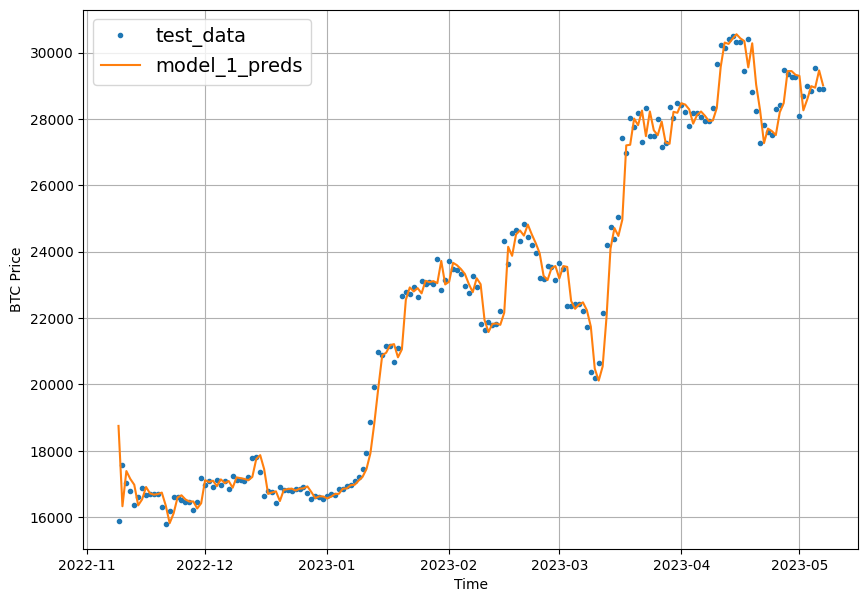

In [55]:
# Let's plot model_1 predictions 
offset=450
plt.figure(figsize=(10,7))

# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_1_preds, 
                 format="-",
                 start=offset, 
                 label='model_1_preds')

## Model 2: Dense (window = 30, horizon = 1)

In [59]:
# Update global variables
HORIZON = 1
WINDOW_SIZE = 30

In [60]:
# Make window data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3125, 3125)

In [61]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2500, 625, 2500, 625)

In [62]:
train_windows[:3], train_labels[:3]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
         399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
         375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
         336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
         378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987, 411.574005, 404.424988, 399.519989,
         377.181   , 375.46701 , 386.944   , 383.61499 , 375.071991,
         359.511993, 328.865997, 320.51001 , 330.07901 , 336.187012,
         352.940002, 365.026001, 361.562012, 362.299011, 378.549011,
         390.414001, 400.869995, 394.77301 , 382.556   , 383.757996],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005, 404.424988, 399.519989, 377.181   ,
         375.46701 , 386.944   ,

In [63]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_2_dense')

# Compile the model
model_2.compile(loss='mae',
                optimizer='adam',
                metrics=['mse', 'mae'])

# Fit the model
model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])


Epoch 1: val_loss improved from inf to 5378.01660, saving model to model_experiments/model_2_dense



Epoch 2: val_loss improved from 5378.01660 to 2536.96802, saving model to model_experiments/model_2_dense



Epoch 3: val_loss improved from 2536.96802 to 2378.87280, saving model to model_experiments/model_2_dense



Epoch 4: val_loss improved from 2378.87280 to 2139.97778, saving model to model_experiments/model_2_dense



Epoch 5: val_loss improved from 2139.97778 to 2020.47278, saving model to model_experiments/model_2_dense



Epoch 6: val_loss improved from 2020.47278 to 1681.71179, saving model to model_experiments/model_2_dense



Epoch 7: val_loss did not improve from 1681.71179

Epoch 8: val_loss improved from 1681.71179 to 1562.81812, saving model to model_experiments/model_2_dense



Epoch 9: val_loss did not improve from 1562.81812

Epoch 10: val_loss improved from 1562.81812 to 1391.28101, saving model to model_experiments/model_2_dense



Epoch 11: val_loss did not improve from 1391.28101

Epoch 12: val_loss did not improve from 1391.28101

Epoch 13: val_loss improved from 1391.28101 to 1326.42078, saving model to model_experiments/model_2_dense



Epoch 14: val_loss did not improve from 1326.42078

Epoch 15: val_loss did not improve from 1326.42078

Epoch 16: val_loss improved from 1326.42078 to 1193.47595, saving model to model_experiments/model_2_dense



Epoch 17: val_loss improved from 1193.47595 to 1180.38220, saving model to model_experiments/model_2_dense



Epoch 18: val_loss improved from 1180.38220 to 1153.33020, saving model to model_experiments/model_2_dense



Epoch 19: val_loss did not improve from 1153.33020

Epoch 20: val_loss did not improve from 1153.33020

Epoch 21: val_loss improved from 1153.33020 to 1143.08899, saving model to model_experiments/model_2_dense



Epoch 22: val_loss improved from 1143.08899 to 1098.38733, saving model to model_experiments/model_2_dense



Epoch 23: val_loss did not improve from 1098.38733

Epoch 24: val_loss improved from 1098.38733 to 1070.70288, saving model to model_experiments/model_2_dense



Epoch 25: val_loss did not improve from 1070.70288

Epoch 26: val_loss did not improve from 1070.70288

Epoch 27: val_loss did not improve from 1070.70288

Epoch 28: val_loss did not improve from 1070.70288

Epoch 29: val_loss improved from 1070.70288 to 1066.91064, saving model to model_experiments/model_2_dense



Epoch 30: val_loss improved from 1066.91064 to 1052.63269, saving model to model_experiments/model_2_dense



Epoch 31: val_loss did not improve from 1052.63269

Epoch 32: val_loss did not improve from 1052.63269

Epoch 33: val_loss did not improve from 1052.63269

Epoch 34: val_loss improved from 1052.63269 to 983.00647, saving model to model_experiments/model_2_dense



Epoch 35: val_loss did not improve from 983.00647

Epoch 36: val_loss did not improve from 983.00647

Epoch 37: val_loss did not improve from 983.00647

Epoch 38: val_loss improved from 983.00647 to 972.47461, saving model to model_experiments/model_2_dense



Epoch 39: val_loss did not improve from 972.47461

Epoch 40: val_loss improved from 972.47461 to 947.56049, saving model to model_experiments/model_2_dense



Epoch 41: val_loss improved from 947.56049 to 938.07062, saving model to model_experiments/model_2_dense



Epoch 42: val_loss did not improve from 938.07062

Epoch 43: val_loss did not improve from 938.07062

Epoch 44: val_loss did not improve from 938.07062

Epoch 45: val_loss did not improve from 938.07062

Epoch 46: val_loss did not improve from 938.07062

Epoch 47: val_loss improved from 938.07062 to 909.61230, saving model to model_experiments/model_2_dense



Epoch 48: val_loss did not improve from 909.61230

Epoch 49: val_loss improved from 909.61230 to 901.23572, saving model to model_experiments/model_2_dense



Epoch 50: val_loss did not improve from 901.23572

Epoch 51: val_loss did not improve from 901.23572

Epoch 52: val_loss did not improve from 901.23572

Epoch 53: val_loss did not improve from 901.23572

Epoch 54: val_loss did not improve from 901.23572

Epoch 55: val_loss did not improve from 901.23572

Epoch 56: val_loss improved from 901.23572 to 888.22699, saving model to model_experiments/model_2_dense



Epoch 57: val_loss did not improve from 888.22699

Epoch 58: val_loss improved from 888.22699 to 886.91119, saving model to model_experiments/model_2_dense



Epoch 59: val_loss did not improve from 886.91119

Epoch 60: val_loss did not improve from 886.91119

Epoch 61: val_loss did not improve from 886.91119

Epoch 62: val_loss did not improve from 886.91119

Epoch 63: val_loss did not improve from 886.91119

Epoch 64: val_loss did not improve from 886.91119

Epoch 65: val_loss did not improve from 886.91119

Epoch 66: val_loss did not improve from 886.91119

Epoch 67: val_loss did not improve from 886.91119

Epoch 68: val_loss did not improve from 886.91119

Epoch 69: val_loss improved from 886.91119 to 882.97681, saving model to model_experiments/model_2_dense



Epoch 70: val_loss improved from 882.97681 to 851.98328, saving model to model_experiments/model_2_dense



Epoch 71: val_loss did not improve from 851.98328

Epoch 72: val_loss did not improve from 851.98328

Epoch 73: val_loss did not improve from 851.98328

Epoch 74: val_loss did not improve from 851.98328

Epoch 75: val_loss did not improve from 851.98328

Epoch 76: val_loss did not improve from 851.98328

Epoch 77: val_loss did not improve from 851.98328

Epoch 78: val_loss did not improve from 851.98328

Epoch 79: val_loss did not improve from 851.98328

Epoch 80: val_loss did not improve from 851.98328

Epoch 81: val_loss did not improve from 851.98328

Epoch 82: val_loss did not improve from 851.98328

Epoch 83: val_loss did not improve from 851.98328

Epoch 84: val_loss did not improve from 851.98328

Epoch 85: val_loss did not improve from 851.98328

Epoch 86: val_loss did not improve from 851.98328

Epoch 87: val_loss improved from 851.98328 to 835.84216, saving model to model_experiments/model_2_dense



Epoch 88: val_loss did not improve from 835.84216

Epoch 89: val_loss did not improve from 835.84216

Epoch 90: val_loss did not improve from 835.84216

Epoch 91: val_loss did not improve from 835.84216

Epoch 92: val_loss did not improve from 835.84216

Epoch 93: val_loss did not improve from 835.84216

Epoch 94: val_loss did not improve from 835.84216

Epoch 95: val_loss did not improve from 835.84216

Epoch 96: val_loss did not improve from 835.84216

Epoch 97: val_loss improved from 835.84216 to 821.44690, saving model to model_experiments/model_2_dense



Epoch 98: val_loss improved from 821.44690 to 820.57812, saving model to model_experiments/model_2_dense



Epoch 99: val_loss did not improve from 820.57812

Epoch 100: val_loss did not improve from 820.57812


In [64]:
# Evaluate model_2 on test data
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 1144.2242 - mse: 2372891.2500 - mae: 1144.2242


[1144.2242431640625, 2372891.25, 1144.2242431640625]

In [65]:
# Load in the best performant model_2
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense')
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 4ms/step - loss: 820.5781 - mse: 1564362.5000 - mae: 820.5781


[820.5780639648438, 1564362.5, 820.5780639648438]

In [66]:
# Get the forecast predicions
model_2_preds = make_preds(model_2, test_windows)

20/20 [==============================] - 0s 4ms/step


In [67]:
# Evaluate results for model_2 prediction
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 820.57806,
 'mse': 1564362.5,
 'rmse': 1250.7448,
 'mape': 2.4299161,
 'mase': 1.0750272}

In [69]:
model_1_results

{'mae': 776.2674,
 'mse': 1427948.8,
 'rmse': 1194.968,
 'mape': 2.2899256,
 'mase': 1.0115616}

In [68]:
naive_results

{'mae': 767.8317,
 'mse': 1377888.6,
 'rmse': 1173.835,
 'mape': 2.2576122,
 'mase': 1.0005691}

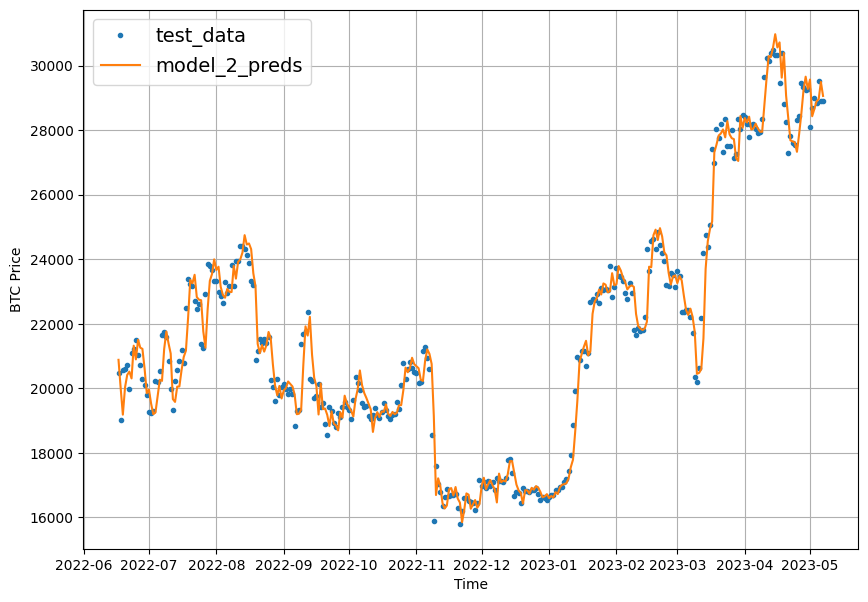

In [70]:
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0],
                 start=offset,
                 label='test_data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_2_preds,
                 start=offset,
                 format="-",
                 label='model_2_preds')